In [30]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
df.head()

,Ticker,Last_Price,Quantity,Position_Value
0,AAPL,232.560,18.00,4186.080
1,AMD,168.580,18.00,3034.440
2,ASML,654.300,6.00,3925.800
3,BNB,857.400,13.09,11223.366
4,BR50,21.855,213.00,4655.115


In [31]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10

,Ticker,Last_Price,Quantity,Position_Value
5,BTC,111968.6300,2.1571,241527.531773
16,META,738.7000,60.0000,44322.000000
8,ETH,4459.3400,4.3100,19219.755400
7,EQQQ,489.6000,39.0000,19094.400000
15,MC,513.1000,22.0000,11288.200000
3,BNB,857.4000,13.0900,11223.366000
12,IWDE,101.5700,96.0000,9750.720000
6,DOGE,0.2153,40270.0000,8670.131000
22,TSLA,345.9800,23.0000,7957.540000
18,NKE,77.9200,79.0000,6155.680000


In [32]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# some Ticker should be adjusted for the data source
port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [33]:
port_list

['BTC-USD',
 'META',
 'ETH-USD',
 'EQQQ.MI',
 'LVMUY',
 'BNB-USD',
 'IWDE.MI',
 'DOGE-USD',
 'TSLA',
 'NKE']

In [34]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [35]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

df_stocks.head()

Ticker,BNB,BTC,DOGE,EQQQ,ETH,IWDE,LVMUY,META,NKE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.924530,127.410179,57.299999,85.065201,208.635391,95.368210,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.373917,134.171707,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.373917,135.069366,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.373917,136.276779,57.160000,84.307289,207.531448,95.106918,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.354431,144.304153,57.060001,84.289238,211.440033,95.022911,30.102667


In [36]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

Y = returns.copy()
Y.head()

Ticker,BNB,BTC,DOGE,EQQQ,ETH,IWDE,LVMUY,META,NKE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002391,0.053069,-0.002443,-0.008910,-0.005291,-0.002740,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,-0.000103,0.058905,-0.001749,-0.000214,0.018834,-0.000883,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.010684,-0.005268,0.003680,-0.009420,0.002164,-0.000491,0.038801


Calculating the portfolio

In [37]:
# # Tickers of factors
# factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
# factors.sort()

# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(factors, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("factors.csv")

In [38]:
# read the data from csv
factors = pd.read_csv("factors.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
factors = factors.loc[:, factors.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
factors.columns = factors.columns.droplevel(0)

# ffill and dropna()
factors = factors.ffill().dropna()

factors.head()

Ticker,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2020-01-02,118.417519,94.607353,89.812912,59.734722,77.545486
2020-01-03,118.398697,93.994476,89.390366,59.771137,76.712593
2020-01-06,118.530289,94.217346,89.518967,59.853073,76.592361
2020-01-07,118.238892,94.087341,89.473030,59.607281,76.703995
2020-01-08,118.868690,94.468079,89.767006,59.734722,76.875725


In [39]:
# Calculating returns
X = factors.pct_change().dropna()

display(X.head())

Ticker,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2020-01-03,-0.000159,-0.006478,-0.004705,0.000610,-0.010741
2020-01-06,0.001111,0.002371,0.001439,0.001371,-0.001567
2020-01-07,-0.002458,-0.001380,-0.000513,-0.004107,0.001457
2020-01-08,0.005326,0.004047,0.003286,0.002138,0.002239
2020-01-09,0.008698,0.008159,0.004605,0.006248,0.001787


In [40]:
# Check data alignment before calculating loadings
print(f"X (factors) shape: {X.shape}")
print(f"Y (assets) shape: {Y.shape}")
print(f"X date range: {X.index.min()} to {X.index.max()}")
print(f"Y date range: {Y.index.min()} to {Y.index.max()}")

# Align the data by finding common dates
common_dates = X.index.intersection(Y.index)
print(f"Common dates: {len(common_dates)}")

if len(common_dates) == 0:
    print("ERROR: No common dates between factors and assets!")
    print("X dates sample:", X.index[:5].tolist())
    print("Y dates sample:", Y.index[:5].tolist())
else:
    # Filter both dataframes to common dates
    X_aligned = X.loc[common_dates].copy()
    Y_aligned = Y.loc[common_dates].copy()
    
    print(f"Aligned X shape: {X_aligned.shape}")
    print(f"Aligned Y shape: {Y_aligned.shape}")
    
    # Remove any remaining NaN values
    before_dropna = len(X_aligned)
    X_aligned = X_aligned.dropna()
    Y_aligned = Y_aligned.loc[X_aligned.index].dropna()
    
    # Ensure both have the same final index
    final_common = X_aligned.index.intersection(Y_aligned.index)
    X_aligned = X_aligned.loc[final_common]
    Y_aligned = Y_aligned.loc[final_common]
    
    print(f"After cleaning - X shape: {X_aligned.shape}, Y shape: {Y_aligned.shape}")
    
    # Now calculate loadings matrix with aligned data
    if len(X_aligned) > 0 and len(Y_aligned) > 0:
        step = 'Forward' # Could be Forward or Backward stepwise regression
        loadings = rp.loadings_matrix(X=X_aligned, Y=Y_aligned, stepwise=step)
        
        display(loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn'))
    else:
        print("ERROR: No data remaining after alignment and cleaning!")

X (factors) shape: (1422, 5)
Y (assets) shape: (2068, 10)
X date range: 2020-01-03 to 2025-08-29
Y date range: 2020-01-03 to 2025-08-31
Common dates: 1422
Aligned X shape: (1422, 5)
Aligned Y shape: (1422, 10)
After cleaning - X shape: (1422, 5), Y shape: (1422, 10)


,const,MTUM,QUAL,SIZE,USMV,VLUE
BNB,0.0030,0.4627,0.0000,1.1056,-0.6699,0.0000
BTC,0.0018,0.4780,0.0000,1.1083,-0.8161,0.0000
DOGE,0.0047,0.7415,0.0000,1.8122,-1.7012,0.0000
EQQQ,0.0003,0.0889,0.9967,0.0000,-0.5205,-0.2050
ETH,0.0019,0.4157,0.7427,0.9888,-1.0856,0.0000
IWDE,0.0001,0.0000,0.3182,0.1592,-0.1502,0.1386
LVMUY,-0.0001,-0.1315,0.6635,0.8014,-0.4362,0.0000
META,0.0003,0.0000,3.1574,0.0000,-1.4391,-0.7845
NKE,-0.0005,-0.3348,1.2208,0.7729,-0.4159,-0.2872
TSLA,0.0016,1.4580,0.0000,2.4404,-1.9136,-0.9736


In [41]:
# Calculating the portfolio that maximizes Sharpe ratio.
# Building the portfolio object with aligned data

if 'Y_aligned' in locals() and 'X_aligned' in locals() and not Y_aligned.empty:
    
    port = rp.Portfolio(returns=Y_aligned)

    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    port.factors = X_aligned
    port.factors_stats(method_mu=method_mu, method_cov=method_cov)

    # Estimate optimal portfolio:

    model='FM' # Factor Model
    rm = 'MV' # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = False # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

    display(w.T)
    
else:
    print("Cannot proceed with portfolio optimization - data alignment issues in previous cell")

,BNB,BTC,DOGE,EQQQ,ETH,IWDE,LVMUY,META,NKE,TSLA
weights,0.20943,0.231642,0.058897,0.245509,0.129652,2.116209e-09,2.900299e-10,1.616190e-09,2.202040e-10,0.12487


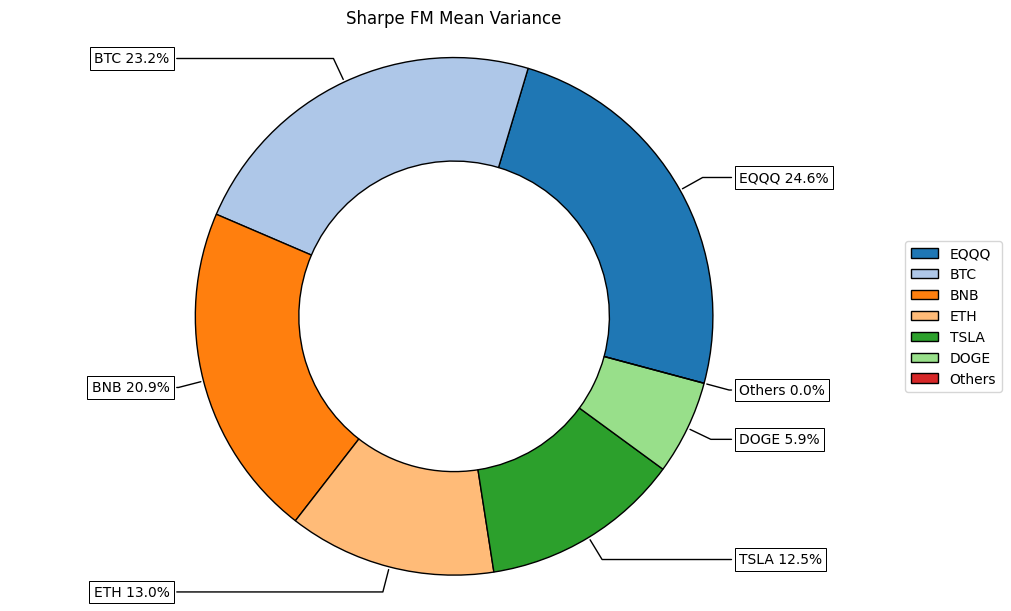

In [42]:
# Plotting the composition of the portfolio
ax = rp.plot_pie(w=w, title='Sharpe FM Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

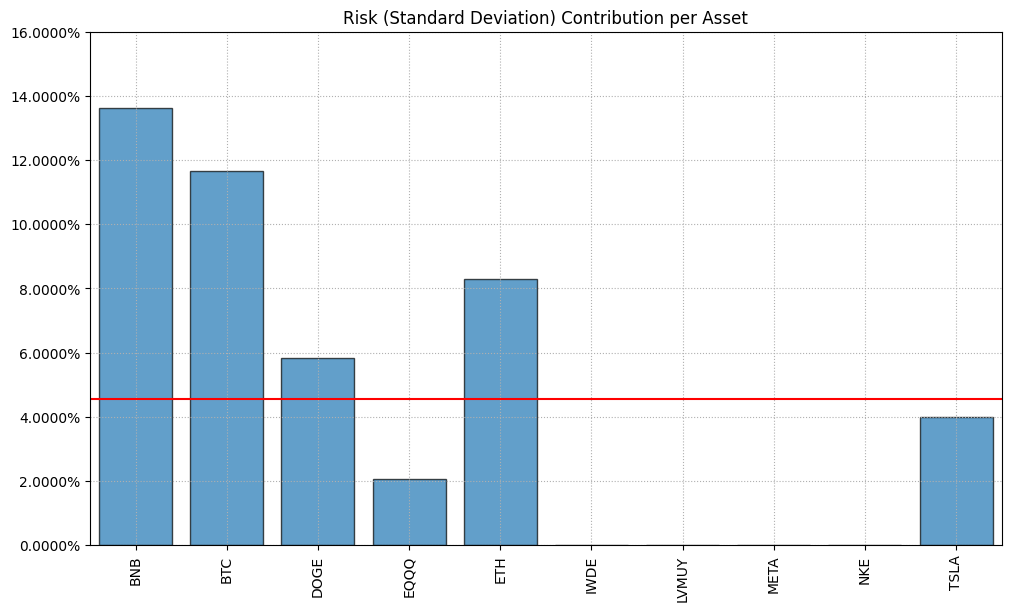

In [43]:
# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)